<a href="https://colab.research.google.com/github/KaushalNaresh/Speech_enhancement_using_convolutional_autoencoders/blob/main/Source_code/Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmark and processing evaluation

In this notebook we will set up the necessary means to evaluate and benchmark  audio preprocessing algorithm against none preprocessing.

In [ ]:
!pip install SpeechRecognition
!pip install jiwer

     |████████████████████████████████| 32.8 MB 51.3 MB/s 
     |████████████████████████████████| 50 kB 3.9 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149868 sha256=4df4c1964922a0d2a6a49ea80ae48800fed2b44aa32721042ba5a64dddeff7cb
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
import os
import speech_recognition as spreg # converting audio to text
from scipy.io.wavfile import write
import numpy as np
from scipy.io import wavfile
import jiwer
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
# Here the notebook needs to be connected with the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Following are some function which might be used or are used during the tests

In [ ]:
def test_function3(y):

    #import pdb; pdb.set_trace();
    amp_max = np.iinfo(np.int16).max

    audio_combined = y  # newest new Nov 26

    audio_combined = scaling(audio_combined)

    data = audio_combined * amp_max / 4

    write("audio_combined.wav", sample_rate, data.astype(np.int16))
    # playsound("audio_combined.wav")

    # playsound("audio_combined.wav")

    output = audio_to_text("audio_combined.wav")
    # print(output)
    
    return output

In [ ]:
def audio_to_text(sound_file):
    recog = spreg.Recognizer()
    with spreg.AudioFile(sound_file) as source:
        speech = recog.record(source)  # use record instead of listning
        try:
            text = recog.recognize_google(speech)
            # print("The file contains: " + text)
        except spreg.UnknownValueError:
            # print("Unable to recognize the audio")
            text = "^"
        except spreg.RequestError as e:
            # print("Request error from Google Speech Recognition service; {}".format(e))
            text = "&"
    
    return text

In [ ]:
def scaling(audio_file):
    audio_file = audio_file - np.mean(audio_file)
    x_max = max(audio_file)

    output = audio_file / x_max
    return output

The dirname needs to be set to the location. Prefilled is a short cut link from personal googledirve to omdena googledrive. It should lead to the folder containing the clean speach, transcripts and noisy data.

In [ ]:
# ToDo Here you need to pass the short cut link to the Folder Method_test_dataset on the Omdena google drive
dirname = '/content/drive/MyDrive/Enzo_as_Noise/'
baseDir_3 = "/content/drive/MyDrive/MS-SNSD Enzo/"

In [ ]:
# Listing all the noisy files
files = os.listdir(dirname + '/NoisySpeech_training')
os.listdir()

print(len(files))
files = sorted(files)
print(files)

3300
['noisy10_SNRdb_0.1_clnsp10.wav', 'noisy10_SNRdb_0.3040816326530612_clnsp10.wav', 'noisy10_SNRdb_0.5081632653061224_clnsp10.wav', 'noisy10_SNRdb_0.7122448979591837_clnsp10.wav', 'noisy10_SNRdb_0.9163265306122449_clnsp10.wav', 'noisy10_SNRdb_1.1204081632653062_clnsp10.wav', 'noisy10_SNRdb_1.3244897959183675_clnsp10.wav', 'noisy10_SNRdb_1.5285714285714287_clnsp10.wav', 'noisy10_SNRdb_1.73265306122449_clnsp10.wav', 'noisy10_SNRdb_1.9367346938775512_clnsp10.wav', 'noisy10_SNRdb_10.1_clnsp10.wav', 'noisy10_SNRdb_2.1408163265306124_clnsp10.wav', 'noisy10_SNRdb_2.344897959183674_clnsp10.wav', 'noisy10_SNRdb_2.548979591836735_clnsp10.wav', 'noisy10_SNRdb_2.753061224489796_clnsp10.wav', 'noisy10_SNRdb_2.9571428571428573_clnsp10.wav', 'noisy10_SNRdb_3.1612244897959187_clnsp10.wav', 'noisy10_SNRdb_3.3653061224489798_clnsp10.wav', 'noisy10_SNRdb_3.5693877551020408_clnsp10.wav', 'noisy10_SNRdb_3.773469387755102_clnsp10.wav', 'noisy10_SNRdb_3.9775510204081637_clnsp10.wav', 'noisy10_SNRdb_4.1816

In [ ]:
# Loading the Transcripts
transcript_dataframe = pd.read_excel(dirname + '/CleanSpeech_transcript_enzo_as_noise.xlsx', header=None)
transcript_dataframe.columns = ['file_name', 'transcript']
transcript_dataframe.set_index('file_name', inplace=True)
transcript_dataframe['transcript'] = transcript_dataframe['transcript'].str.split().str.join(' ')

In [ ]:
# Setting WER Transformations
transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemovePunctuation(),
    jiwer.ReduceToListOfListOfWords(word_delimiter=" ")
]) 

# Naresh's Code Starts here

In [ ]:
import librosa as lb
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import librosa.display as lbdp
import tensorflow.keras
import math
import os
import keras
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.constraints import max_norm
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
import soundfile as sf
import glob

In [ ]:
def unet(pretrained_weights = None,input_size = (128,128,1)):
    #size filter input
    size_filter_in = 16
    #normal initialization of weights
    kernel_init = 'he_normal'
    #To apply leaky relu after the conv layer 
    activation_layer = None
    inputs = Input(input_size)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.7)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU()(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv6)
    conv6 = LeakyReLU()(conv6)
    up7 = Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv6))
    up7 = LeakyReLU()(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv7)
    conv7 = LeakyReLU()(conv7)
    up8 = Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv7))
    up8 = LeakyReLU()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv8)
    conv8 = LeakyReLU()(conv8)

    up9 = Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv8))
    up9 = LeakyReLU()(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = 'adam', loss = tf.keras.losses.Huber(), metrics = ['mae'])

    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [ ]:
## function to get log spectrograms of noisy signals
def get_log_spectograms(signals, hopLength, frameSize, dim_square_spec):

  ## log_mag_spectograms = []
  ## log_phase_spectograms = []

  m_mag_db = np.zeros((len(signals), dim_square_spec, dim_square_spec))
  m_phase = np.zeros((len(signals), dim_square_spec, dim_square_spec), dtype=complex)
  i = 0

  for signal in signals:

    stftaudio = lb.stft(signal, n_fft=frameSize, hop_length=hopLength)           ## Calculating short time fourier transform
    stftaudio_magnitude, stftaudio_phase =  lb.magphase(stftaudio)               ## separating magnitude and phase
    stftaudio_magnitude_db = lb.amplitude_to_db(stftaudio_magnitude, ref=np.max) ## Converting magnitude to log values
   
    m_mag_db[i, :, :] = stftaudio_magnitude_db
    m_phase[i, :, :] = stftaudio_phase
    i = i+1

  return m_mag_db, m_phase

In [ ]:
def scaled_in(matrix_spec):
    "global scaling apply to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46)/50
    return matrix_spec

def scaled_ou(matrix_spec):
    "global scaling apply to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec -6 )/82
    return matrix_spec

def inv_scaled_in(matrix_spec):
    "inverse global scaling apply to noisy voices spectrograms"
    matrix_spec = matrix_spec * 50 - 46
    return matrix_spec

def inv_scaled_ou(matrix_spec):
    "inverse global scaling apply to noise models spectrograms"
    matrix_spec = matrix_spec * 82 + 6
    return matrix_spec

In [ ]:
def magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):
    """This functions reverts a spectrogram to an audio"""

    stftaudio_magnitude_rev = lb.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # taking magnitude and phase of audio
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = lb.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct

def matrix_spectrogram_to_numpy_audio(m_mag_db, m_phase, frame_length, hop_length_fft)  :
    """This functions reverts the matrix spectrograms to numpy audio"""

    list_audio = []

    nb_spec = m_mag_db.shape[0]

    for i in range(nb_spec):

        audio_reconstruct = magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, m_mag_db[i], m_phase[i])
        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)

In [ ]:
def NareshPreprocessing(NosiySpeechPath, CleanSpeechPath):

  generator_nn=unet(pretrained_weights = baseDir_3+'model_best.h5')

  signal_noisy ,_ = lb.load(NosiySpeechPath, 8000)
  signal_noisy = lb.util.fix_length(signal_noisy, 5*8064)
  signal_noisy = signal_noisy.reshape((5, 8064))

  signal_clean ,_ = lb.load(CleanSpeechPath, 8000)
  signal_clean = lb.util.fix_length(signal_clean, 5*8064)
  signal_clean = signal_clean.reshape((5, 8064))

  noisy_test_mag, noisy_test_phase = get_log_spectograms(signal_noisy, 63, 255, 128)
  clean_test_mag, clean_test_phase = get_log_spectograms(signal_clean, 63, 255, 128)

  norm_noisy_test_mag = scaled_in(noisy_test_mag)
  norm_clean_test_mag = scaled_ou(clean_test_mag)

  norm_noisy_test_mag_reshaped = norm_noisy_test_mag.reshape(norm_noisy_test_mag.shape[0], norm_noisy_test_mag.shape[1], norm_noisy_test_mag.shape[2], 1)

  prediction = generator_nn.predict(norm_noisy_test_mag_reshaped)
  inv_sca_X_pred = inv_scaled_ou(prediction)

  X_denoise = noisy_test_mag - inv_sca_X_pred[:,:,:,0]

  rec_audio = matrix_spectrogram_to_numpy_audio(X_denoise, clean_test_phase, 8064, 63)

  nb_samples = rec_audio.shape[0]

  denoise_long = rec_audio.reshape(1, nb_samples * 8064)*10

  return denoise_long[0,:]


# Naresh's code end here

In [ ]:
sample_rate = 8000
y  = files
results = []
for name in tqdm(files):
  
  snr = round(float(name.split('_')[2]), 1)
  clean_file_name = name.split('_')[3]
  noisy_file_name = name.split('_')[0]
  if transcript_dataframe.loc[clean_file_name, 'transcript'] != 'exclude':
    dirname1 = dirname + '/NoisySpeech_training' + '/' + name
    dirname2 = dirname + '/CleanSpeech_training' + '/' + clean_file_name

    # The script is loading the noisy Audio file
    # Fs1, y_text = wavfile.read(dirname1)         # Commented by Naresh

    # Now you need to insert your preproccessing here before the test function is called

    y_text = NareshPreprocessing(dirname1, dirname2)

    # Calculating WER, MER and WIL
    test_result = test_function3(y_text)
    clear_speech = transcript_dataframe.loc[clean_file_name, 'transcript']
    wer = jiwer.wer(clear_speech, 
                    test_result, 
                    truth_transform=transformation, 
                    hypothesis_transform=transformation)
    mer = jiwer.mer(clear_speech, 
                    test_result, 
                    truth_transform=transformation, 
                    hypothesis_transform=transformation)
    wil = jiwer.wil(clear_speech, 
                    test_result, 
                    truth_transform=transformation, 
                    hypothesis_transform=transformation)

    results.append([name, noisy_file_name, clean_file_name, snr, wer, mer, wil, clear_speech, test_result])



  0%|          | 4/3300 [00:27<5:49:57,  6.37s/it]

  0%|          | 5/3300 [00:33<5:49:43,  6.37s/it]

100%|██████████| 3300/3300 [3:06:49<00:00,  3.40s/it]


In [ ]:
data_result = pd.DataFrame(results)
data_result.columns = ['file_name', 'noisy_file_name', 'clean_file_name', 'SNR_level', 'WER', 'MER', 'WIL', 'clean_text', 'audio_text']

In [ ]:
data_result.head()

,file_name,noisy_file_name,clean_file_name,SNR_level,WER,MER,WIL,clean_text,audio_text
0,noisy10_SNRdb_0.1_clnsp10.wav,noisy10,clnsp10.wav,0.1,0.470588,0.470588,0.523529,when the sunlight strikes raindrops in the air...,when the sunlight strikes raindrops act as a f...
1,noisy10_SNRdb_0.3040816326530612_clnsp10.wav,noisy10,clnsp10.wav,0.3,0.470588,0.470588,0.523529,when the sunlight strikes raindrops in the air...,when the sunlight strikes raindrops act as a f...
2,noisy10_SNRdb_0.5081632653061224_clnsp10.wav,noisy10,clnsp10.wav,0.5,0.470588,0.470588,0.523529,when the sunlight strikes raindrops in the air...,when the sunlight strikes raindrops act as a f...
3,noisy10_SNRdb_0.7122448979591837_clnsp10.wav,noisy10,clnsp10.wav,0.7,0.470588,0.470588,0.523529,when the sunlight strikes raindrops in the air...,when the sunlight strikes raindrops act as a f...
4,noisy10_SNRdb_0.9163265306122449_clnsp10.wav,noisy10,clnsp10.wav,0.9,0.470588,0.470588,0.523529,when the sunlight strikes raindrops in the air...,when the sunlight strikes raindrops act as a f...


In [ ]:
data_result.describe()

,SNR_level,WER,MER,WIL
count,2950.000000,2950.000000,2950.000000,2950.000000
mean,5.100000,0.660975,0.658717,0.732220
std,2.953465,0.247578,0.248844,0.220543
min,0.100000,0.071429,0.071429,0.137755
25%,2.500000,0.500000,0.500000,0.583333
50%,5.100000,0.600000,0.600000,0.739583
75%,7.700000,0.933333,0.933333,0.952381
max,10.100000,1.000000,1.000000,1.000000


In [ ]:
data_result.to_csv(dirname + 'Naresh_results.csv')

In [ ]:
results = pd.read_csv(dirname + 'Naresh_results.csv')
results.head()

,Unnamed: 0,file_name,noisy_file_name,clean_file_name,SNR_level,WER,MER,WIL,clean_text,audio_text
0,0,noisy10_SNRdb_0.1_clnsp10.wav,noisy10,clnsp10.wav,0.1,0.470588,0.470588,0.523529,when the sunlight strikes raindrops in the air...,when the sunlight strikes raindrops act as a f...
1,1,noisy10_SNRdb_0.3040816326530612_clnsp10.wav,noisy10,clnsp10.wav,0.3,0.470588,0.470588,0.523529,when the sunlight strikes raindrops in the air...,when the sunlight strikes raindrops act as a f...
2,2,noisy10_SNRdb_0.5081632653061224_clnsp10.wav,noisy10,clnsp10.wav,0.5,0.470588,0.470588,0.523529,when the sunlight strikes raindrops in the air...,when the sunlight strikes raindrops act as a f...
3,3,noisy10_SNRdb_0.7122448979591837_clnsp10.wav,noisy10,clnsp10.wav,0.7,0.470588,0.470588,0.523529,when the sunlight strikes raindrops in the air...,when the sunlight strikes raindrops act as a f...
4,4,noisy10_SNRdb_0.9163265306122449_clnsp10.wav,noisy10,clnsp10.wav,0.9,0.470588,0.470588,0.523529,when the sunlight strikes raindrops in the air...,when the sunlight strikes raindrops act as a f...


In [ ]:
bool_list = [results['clean_text'] != results['audio_text']]
int_list = map(int, bool_list[0])
temp = list(int_list)
print(f"{sum(temp)} {len(temp)}")

2950 2950


In [ ]:
grouped = results.groupby('SNR_level')[('WER', 'MER', 'WIL')].mean()
grouped.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,WER,MER,WIL
SNR_level,,,
0.1,0.769633,0.768423,0.828812
0.3,0.766376,0.765166,0.825393
0.5,0.765113,0.763903,0.822892
0.7,0.756739,0.755528,0.817868
0.9,0.760526,0.758750,0.822328


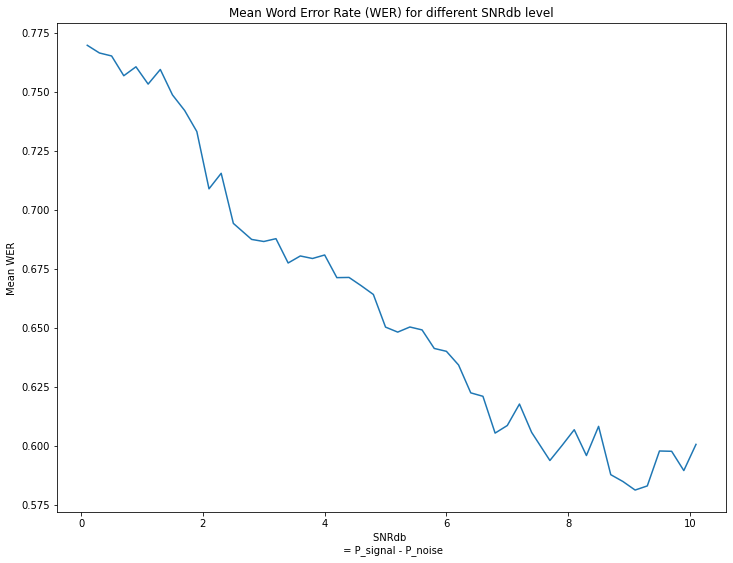

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(grouped["WER"])
plt.title('Mean Word Error Rate (WER) for different SNRdb level')
plt.xlabel('SNRdb \n = P_signal - P_noise')
plt.ylabel('Mean WER')
plt.show()

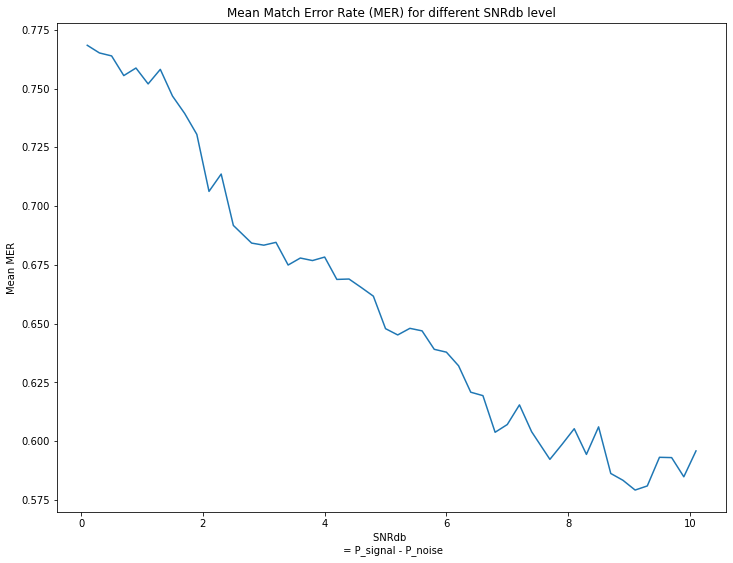

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(grouped["MER"])
plt.title('Mean Match Error Rate (MER) for different SNRdb level')
plt.xlabel('SNRdb \n = P_signal - P_noise')
plt.ylabel('Mean MER')
plt.show()

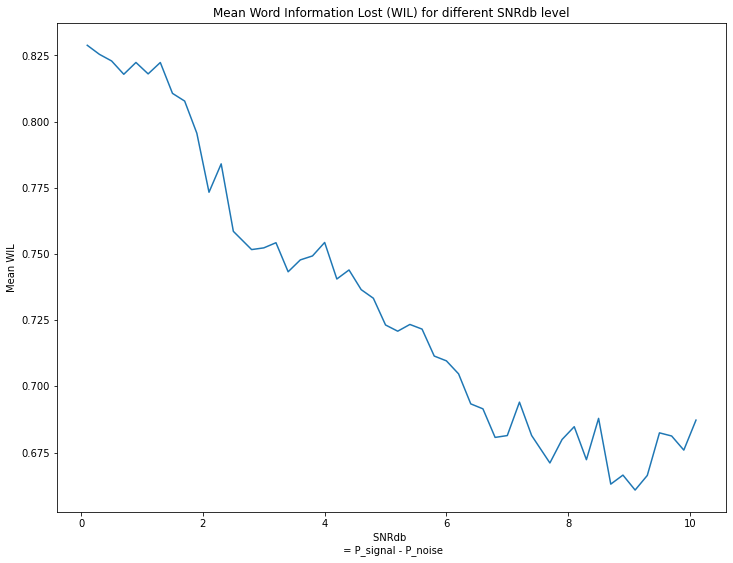

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(grouped["WIL"])
plt.title('Mean Word Information Lost (WIL) for different SNRdb level')
plt.xlabel('SNRdb \n = P_signal - P_noise')
plt.ylabel('Mean WIL')
plt.show()